In [ ]:
pip install pandasql

Import required Python packages:

In [63]:
import pandas as pd
import pandasql as ps
from pandasql import sqldf
# Define a reusable function for running SQL queries
run_query = lambda query: sqldf(query, globals())

Import csv as a dataframe:

In [8]:
or_df = pd.read_csv('/Users/kelly.bergen/Documents/Kelly Personal/Personal Profile/Untitled/Portfolio/2022_Q1_OR_Utilization.csv')

Begin SQL:

In [9]:
# Preview the data
print(sqldf("""
    select *
    from or_df
    limit 10;
"""))

   Encounter ID      Date  OR Suite        Service  CPT Code  \
0         10001  01/03/22         1       Podiatry     28110   
1         10002  01/03/22         1       Podiatry     28055   
2         10003  01/03/22         1       Podiatry     28297   
3         10004  01/03/22         1       Podiatry     28296   
4         10005  01/03/22         2    Orthopedics     27445   
5         10006  01/03/22         2    Orthopedics     27445   
6         10007  01/03/22         3  Ophthalmology     66982   
7         10008  01/03/22         3  Ophthalmology     66982   
8         10009  01/03/22         3  Ophthalmology     66982   
9         10010  01/03/22         3  Ophthalmology     66982   

                             CPT Description  Booked Time (min)  \
0   Partial ostectomy, fifth metatarsal head                 90   
1  Neurectomy, intrinsic musculature of foot                 60   
2                       Lapidus bunionectomy                150   
3         Bunionectomy with

In [13]:
# Data quality checks (null values, data types, unique values)
or_df.info()
or_df.nunique()
or_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Encounter ID       2172 non-null   int64 
 1   Date               2172 non-null   object
 2   OR Suite           2172 non-null   int64 
 3   Service            2172 non-null   object
 4   CPT Code           2172 non-null   int64 
 5   CPT Description    2172 non-null   object
 6   Booked Time (min)  2172 non-null   int64 
 7   OR Schedule        2172 non-null   object
 8   Wheels In          2172 non-null   object
 9   Start Time         2172 non-null   object
 10  End Time           2172 non-null   object
 11  Wheels Out         2172 non-null   object
dtypes: int64(4), object(8)
memory usage: 203.8+ KB


,Encounter ID,OR Suite,CPT Code,Booked Time (min)
count,2172.000000,2172.000000,2172.000000,2172.000000
mean,11086.500000,4.288674,44881.405617,77.189227
std,627.146713,2.163514,18087.419079,30.430015
min,10001.000000,1.000000,14060.000000,30.000000
25%,10543.750000,3.000000,28296.000000,60.000000
50%,11086.500000,4.000000,42826.000000,60.000000
75%,11629.250000,6.000000,66982.000000,90.000000
max,12172.000000,8.000000,69436.000000,180.000000


In [37]:
# Convert the timestamps to datetime objects
or_df[['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']] = or_df[['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']].apply(pd.to_datetime, format='%m/%d/%y %I:%M %p')
or_df['Date'] = pd.to_datetime(or_df['Date'], format='%m/%d/%y')

In [38]:
# Rename and format the columns to be more sql friendly
or_clean = sqldf("""
    select
        "Encounter ID" as encounter_id
        , "Date" as encounter_date
        , "OR Suite" as or_suite
        , "Service" as service
        , "CPT Code" as cpt_code
        , "CPT Description" as cpt_description
        , "Booked Time (min)" as booked_time_min
        , "OR Schedule" as or_schedule
        , "Wheels In" as wheels_in
        , "Start Time" as start_time
        , "End Time" as end_time
        , "Wheels Out" as wheels_out          
    from or_df
""")
print(or_clean.head())

   encounter_id              encounter_date  or_suite      service  cpt_code  \
0         10001  2022-01-03 00:00:00.000000         1     Podiatry     28110   
1         10002  2022-01-03 00:00:00.000000         1     Podiatry     28055   
2         10003  2022-01-03 00:00:00.000000         1     Podiatry     28297   
3         10004  2022-01-03 00:00:00.000000         1     Podiatry     28296   
4         10005  2022-01-03 00:00:00.000000         2  Orthopedics     27445   

                             cpt_description  booked_time_min  \
0   Partial ostectomy, fifth metatarsal head               90   
1  Neurectomy, intrinsic musculature of foot               60   
2                       Lapidus bunionectomy              150   
3         Bunionectomy with distal osteotomy              120   
4        Arthroplasty, knee, hinge prothesis              120   

                  or_schedule                   wheels_in  \
0  2022-01-03 07:00:00.000000  2022-01-03 07:05:00.000000   
1  202

Business Problems
1. An OR running late makes resource planning more difficult and puts unnecessary strain
on Example Hospital’s limited staffing and resources. What causes services to run late
and what recommendations could you make to ensure more consistency?
2. The OR room is cleaned and prepped between services. How long does this take on
average? Does it take more or less time when the prior service is running late?

In [43]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [88]:
# Set up time intervals in question
# 1. Scheduled to Wheels In
# 2. Wheels in to start
# 3. Start to End
# 4. End to Wheels Out
# 5. Scheduled to Wheels Out

or_intervals = sqldf("""
    with
        intervals as (
            select *
                , strftime('%Y-%m-%d %H:%M:%S', or_schedule, '+' || booked_time_min || ' minutes') as scheduled_end_time
                , (strftime('%s', wheels_in) - strftime('%s', or_schedule))/60 as scheduled_to_wheels_in_min
                , (strftime('%s', start_time) - strftime('%s', or_schedule))/60 as or_schedule_to_start_min
                , (strftime('%s', start_time) - strftime('%s', wheels_in))/60 as wheels_in_to_start_min
                , (strftime('%s', end_time) - strftime('%s', start_time))/60 as start_to_end_min
                , (strftime('%s', wheels_out) - strftime('%s', end_time))/60 as end_to_wheels_out_min
                , (strftime('%s', wheels_out) - strftime('%s', wheels_in))/60 as wheels_in_to_wheels_out_min
                , (strftime('%s', wheels_out) - strftime('%s', or_schedule))/60 as scheduled_to_wheels_out_min 

                , row_number() over(partition by or_suite, encounter_date order by start_time) as surgery_start_order_by_day
            from or_clean
        )
    
        , late_indicators as (
            select *
                , booked_time_min - start_to_end_min as surgical_time_vs_booked
                , case when booked_time_min < start_to_end_min then 1 else 0 end as has_surgery_over_booked_time
                , booked_time_min - wheels_in_to_wheels_out_min as in_room_time_vs_booked
                , case when booked_time_min < wheels_in_to_wheels_out_min then 1 else 0 end as has_in_room_time_over_booked_time
                , lead(encounter_id) over(partition by or_suite, encounter_date order by start_time) as next_encounter_id
                , lag(encounter_id) over(partition by or_suite, encounter_date order by start_time) as prior_encounter_id                     
            from intervals         
        )
                     
    select 
        current_encounters.*           
        , case when current_encounters.scheduled_to_wheels_in_min > 5 then 1 else 0 end as started_late
        , case when (strftime('%s', current_encounters.wheels_out) - strftime('%s', current_encounters.scheduled_end_time))/60   > 5 then 1 else 0 end as ended_late
        , (strftime('%s', current_encounters.wheels_out) - strftime('%s', current_encounters.scheduled_end_time))/60 as scheduled_end_to_wheels_out_min
        , strftime('%w',current_encounters.encounter_date) as day_of_week
        , prior_encounters.service as prior_service
        , prior_encounters.or_schedule as prior_or_schedule
        , prior_encounters.wheels_in as prior_wheels_in
        , prior_encounters.start_time as prior_start_time
        , prior_encounters.end_time as prior_end_time
        , prior_encounters.wheels_out as prior_wheels_out
        , prior_encounters.scheduled_to_wheels_in_min as prior_scheduled_to_wheels_in_min
        , prior_encounters.or_schedule_to_start_min as prior_or_schedule_to_start_min
        , prior_encounters.wheels_in_to_start_min as prior_wheels_in_to_start_min
        , prior_encounters.start_to_end_min as prior_start_to_end_min
        , prior_encounters.end_to_wheels_out_min as prior_end_to_wheels_out_min
        , prior_encounters.wheels_in_to_wheels_out_min as prior_wheels_in_to_wheels_out_min
        , prior_encounters.scheduled_to_wheels_out_min  as prior_scheduled_to_wheels_out_min
        , prior_encounters.surgery_start_order_by_day as prior_surgery_start_order_by_day
        , prior_encounters.surgical_time_vs_booked as prior_surgical_time_vs_booked
        , prior_encounters.has_surgery_over_booked_time as prior_has_surgery_over_booked_time
        , prior_encounters.in_room_time_vs_booked as prior_in_room_time_vs_booked
        , prior_encounters.has_in_room_time_over_booked_time as prior_has_in_room_time_over_booked_time
        , case when prior_encounters.scheduled_to_wheels_in_min > 5 then 1 else 0 end as prior_started_late
        , case when (strftime('%s', prior_encounters.wheels_out) - strftime('%s', prior_encounters.scheduled_end_time))/60   > 5 then 1 else 0 end as prior_ended_late        
        , (strftime('%s', prior_encounters.wheels_out) - strftime('%s', prior_encounters.scheduled_end_time))/60 as prior_scheduled_end_to_wheels_out_min             
        , next_encounters.service as next_service
        , next_encounters.or_schedule as next_or_schedule
        , next_encounters.wheels_in as next_wheels_in
        , next_encounters.start_time as next_start_time
        , next_encounters.end_time as next_end_time
        , next_encounters.wheels_out as next_wheels_out
        , next_encounters.scheduled_to_wheels_in_min as next_scheduled_to_wheels_in_min
        , next_encounters.or_schedule_to_start_min as next_or_schedule_to_start_min
        , next_encounters.wheels_in_to_start_min as next_wheels_in_to_start_min
        , next_encounters.start_to_end_min as next_start_to_end_min
        , next_encounters.end_to_wheels_out_min as next_end_to_wheels_out_min
        , next_encounters.wheels_in_to_wheels_out_min as next_wheels_in_to_wheels_out_min
        , next_encounters.scheduled_to_wheels_out_min as next_scheduled_to_wheels_out_min
        , next_encounters.surgery_start_order_by_day as next_surgery_start_order_by_day
        , next_encounters.surgical_time_vs_booked as next_surgical_time_vs_booked
        , next_encounters.has_surgery_over_booked_time as next_has_surgery_over_booked_time
        , next_encounters.in_room_time_vs_booked as next_in_room_time_vs_booked
        , next_encounters.has_in_room_time_over_booked_time as next_has_in_room_time_over_booked_time
        , case when next_encounters.scheduled_to_wheels_in_min > 5 then 1 else 0 end as next_started_late
        , case when (strftime('%s', next_encounters.wheels_out) - strftime('%s', next_encounters.scheduled_end_time))/60   > 5 then 1 else 0 end as next_ended_late 
        , (strftime('%s', next_encounters.wheels_out) - strftime('%s', next_encounters.scheduled_end_time))/60 as next_scheduled_end_to_wheels_out_min              
        , next_encounters.wheels_in - current_encounters.wheels_out as turnaround_time_min
        , next_encounters.or_schedule - current_encounters.wheels_out as time_to_next_scheduled_case_min
                     
                                       
    from late_indicators as current_encounters
    left join late_indicators as prior_encounters on current_encounters.prior_encounter_id = prior_encounters.encounter_id
    left join late_indicators as next_encounters on current_encounters.next_encounter_id = next_encounters.encounter_id
                      
""")
print(or_intervals.head())
## Add Leading/Lagging to calculate the turnaround time between procedures - also an indicator for how long the room was empty. 
## Does a late start correlate with a longer time vs booked? 
## Predictors of over time: service, room, whether the first surgery started on time, whether the OR is utilized by multiple services, cpt 

   encounter_id              encounter_date  or_suite   service  cpt_code  \
0         10001  2022-01-03 00:00:00.000000         1  Podiatry     28110   
1         10002  2022-01-03 00:00:00.000000         1  Podiatry     28055   
2         10003  2022-01-03 00:00:00.000000         1  Podiatry     28297   
3         10004  2022-01-03 00:00:00.000000         1  Podiatry     28296   
4         10034  2022-01-04 00:00:00.000000         1  Podiatry     28296   

                             cpt_description  booked_time_min  \
0   Partial ostectomy, fifth metatarsal head               90   
1  Neurectomy, intrinsic musculature of foot               60   
2                       Lapidus bunionectomy              150   
3         Bunionectomy with distal osteotomy              120   
4         Bunionectomy with distal osteotomy              120   

                  or_schedule                   wheels_in  \
0  2022-01-03 07:00:00.000000  2022-01-03 07:05:00.000000   
1  2022-01-03 08:45:00.0

In [31]:
or_intervals.describe()

,encounter_id,or_suite,cpt_code,booked_time_min,scheduled_to_wheels_in_min,or_schedule_to_start_min,wheels_in_to_start_min,start_to_end_min,end_to_wheels_out_min,wheels_in_to_wheels_out_min,scheduled_to_wheels_out_min,surgery_start_order_by_day,surgical_time_vs_booked,has_surgery_over_booked_time,in_room_time_vs_booked,has_in_room_time_over_booked_time,next_encounter_id,prior_encounter_id,prior_scheduled_to_wheels_in_min,prior_or_schedule_to_start_min,prior_wheels_in_to_start_min,prior_start_to_end_min,prior_end_to_wheels_out_min,prior_wheels_in_to_wheels_out_min,prior_scheduled_to_wheels_out_min,prior_surgery_start_order_by_day,prior_surgical_time_vs_booked,prior_has_surgery_over_booked_time,prior_in_room_time_vs_booked,prior_has_in_room_time_over_booked_time,next_scheduled_to_wheels_in_min,next_or_schedule_to_start_min,next_wheels_in_to_start_min,next_start_to_end_min,next_end_to_wheels_out_min,next_wheels_in_to_wheels_out_min,next_scheduled_to_wheels_out_min,next_surgery_start_order_by_day,next_surgical_time_vs_booked,next_has_surgery_over_booked_time,next_in_room_time_vs_booked,next_has_in_room_time_over_booked_time,turnaround_time_min,time_to_next_scheduled_case_min
count,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.0,1676.000000,1676.000000,1676.0,1676.0
mean,11086.500000,4.288674,44881.405617,77.189227,35.542818,57.072744,21.529926,45.475138,12.691989,79.697053,115.239871,2.921271,31.714088,0.008287,-2.507827,0.569521,11088.931384,11087.931384,26.289976,47.423031,21.133055,44.676611,12.519093,78.328759,104.618735,2.489857,30.949881,0.010740,-2.702267,0.584726,43.972554,65.484487,21.511933,42.815632,12.781026,77.108592,121.081146,3.489857,32.318616,0.0,-1.974344,0.538783,0.0,0.0
std,627.146713,2.163514,18087.419079,30.430015,37.932126,40.602944,6.416851,26.742297,2.667420,31.822390,52.844854,1.676447,13.845822,0.090677,15.364583,0.495257,626.695574,626.695574,29.007267,32.352453,6.700115,27.233986,2.675080,32.434290,47.182221,1.492034,14.110307,0.103106,15.617908,0.492916,39.306866,42.385949,6.141261,24.778156,2.807308,30.074179,55.190974,1.492034,13.976737,0.0,15.292919,0.498642,0.0,0.0
min,10001.000000,1.000000,14060.000000,30.000000,-55.000000,-51.000000,3.000000,12.000000,3.000000,19.000000,-31.000000,1.000000,-3.000000,0.000000,-42.000000,0.000000,10002.000000,10001.000000,-50.000000,-46.000000,3.000000,12.000000,3.000000,19.000000,-31.000000,1.000000,-3.000000,0.000000,-42.000000,0.000000,-55.000000,-51.000000,3.000000,12.000000,3.000000,19.000000,-31.000000,2.000000,10.000000,0.0,-27.000000,0.000000,0.0,0.0
25%,10543.750000,3.000000,28296.000000,60.000000,5.000000,28.000000,18.000000,28.000000,11.000000,62.000000,78.000000,2.000000,25.000000,0.000000,-13.000000,0.000000,10546.750000,10545.750000,4.000000,24.000000,18.000000,27.000000,11.000000,58.000000,70.000000,1.000000,24.000000,0.000000,-14.000000,0.000000,15.000000,38.000000,18.000000,27.000000,11.000000,61.000000,93.000000,2.000000,25.750000,0.0,-14.000000,0.000000,0.0,0.0
50%,11086.500000,4.000000,42826.000000,60.000000,25.000000,48.000000,23.000000,35.000000,13.000000,73.000000,115.000000,3.000000,30.000000,0.000000,-3.000000,1.000000,11089.500000,11088.500000,19.000000,45.000000,23.000000,35.000000,13.000000,73.000000,107.000000,2.000000,30.000000,0.000000,-3.000000,1.000000,39.000000,64.000000,23.000000,35.000000,13.000000,74.000000,125.000000,3.000000,30.000000,0.0,-3.000000,1.000000,0.0,0.0
75%,11629.250000,6.000000,66982.000000,90.000000,58.000000,80.000000,25.000000,58.000000,14.000000,96.000000,148.000000,4.000000,36.000000,0.000

In [28]:
print(sqldf("""
    select *
    from or_intervals
limit 10;
                       
"""))

# or_schedule_to_start_min<0   6 procedures */
# scheduled_to_wheels_in_min	 < 0 /*189 procedures 

# Some ORs only have one service. Some services operate in multiple ORs. 

   encounter_id encounter_date  or_suite   service  cpt_code  \
0         10001       01/03/22         1  Podiatry     28110   
1         10002       01/03/22         1  Podiatry     28055   
2         10003       01/03/22         1  Podiatry     28297   
3         10004       01/03/22         1  Podiatry     28296   
4         10034       01/04/22         1  Podiatry     28296   
5         10035       01/04/22         1  Podiatry     28289   
6         10036       01/04/22         1  Podiatry     28296   
7         10071       01/05/22         1  Podiatry     28060   
8         10072       01/05/22         1  Podiatry     28060   
9         10073       01/05/22         1  Podiatry     28285   

                              cpt_description  booked_time_min  \
0    Partial ostectomy, fifth metatarsal head               90   
1   Neurectomy, intrinsic musculature of foot               60   
2                        Lapidus bunionectomy              150   
3          Bunionectomy with di

In [49]:
print(sqldf("""
    select encounter_date
        , strftime('%w',encounter_date) day_of_week
        , count(*) as surgeries
    from or_intervals
group by 1, 2
            order by 1           
"""))


                encounter_date Day  surgeries
0   2022-01-03 00:00:00.000000   1         33
1   2022-01-04 00:00:00.000000   2         37
2   2022-01-05 00:00:00.000000   3         33
3   2022-01-06 00:00:00.000000   4         33
4   2022-01-07 00:00:00.000000   5         38
5   2022-01-10 00:00:00.000000   1         33
6   2022-01-11 00:00:00.000000   2         32
7   2022-01-12 00:00:00.000000   3         34
8   2022-01-13 00:00:00.000000   4         37
9   2022-01-14 00:00:00.000000   5         33
10  2022-01-18 00:00:00.000000   2         33
11  2022-01-19 00:00:00.000000   3         38
12  2022-01-20 00:00:00.000000   4         32
13  2022-01-21 00:00:00.000000   5         34
14  2022-01-24 00:00:00.000000   1         37
15  2022-01-25 00:00:00.000000   2         33
16  2022-01-26 00:00:00.000000   3         37
17  2022-01-27 00:00:00.000000   4         33
18  2022-01-28 00:00:00.000000   5         33
19  2022-01-31 00:00:00.000000   1         33
20  2022-02-01 00:00:00.000000   2

Findings: There are 3 months of data, 62 days (Jan 1 2022 - Mar 31 2022). The only day missing is MLK, but otherwise has complete Mon-Fri, no weekends.

In [55]:
print(sqldf("""
    select 
        strftime('%w',encounter_date) day_of_week
        , count(*) as total_surgeries
        , count(*)/count(distinct encounter_date) as avg_surgeries_per_day
        , avg(booked_time_min) as avg_booked_time_min
        , avg(start_to_end_min) as avg_surgical_time_min
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
        , avg(wheels_in_to_wheels_out_min) - avg(booked_time_min)  as avg_time_over_booked_min
        , sum(booked_time_min) as total_booked_time_min
        , min(or_schedule) as first_case
        , max(or_schedule) as last_case
    from or_intervals
group by 1
order by 1           
"""))

  day_of_week  total_surgeries  avg_surgeries_per_day  avg_booked_time_min  \
0           1              388                     35            76.817010   
1           2              456                     35            76.480263   
2           3              455                     35            76.582418   
3           4              451                     34            75.465632   
4           5              422                     35            80.793839   

   avg_surgical_time_min  avg_in_room_time_min  avg_time_over_booked_min  \
0              45.239691             79.319588                  2.502577   
1              44.967105             79.225877                  2.745614   
2              45.019780             79.472527                  2.890110   
3              44.248337             79.170732                  3.705100   
4              48.042654             81.357820                  0.563981   

   total_booked_time_min                  first_case  \
0                 

In [56]:
print(sqldf("""
    select 
        or_suite
        , count(*) as total_surgeries
        , count(*)/count(distinct encounter_date) as avg_surgeries_per_day
        , avg(booked_time_min) as avg_booked_time_min
        , avg(start_to_end_min) as avg_surgical_time_min
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
         , avg(wheels_in_to_wheels_out_min) - avg(booked_time_min)  as avg_time_over_booked_min
        , sum(booked_time_min) as total_booked_time_min
        , min(or_schedule) as first_case
        , max(or_schedule) as last_case
    from or_intervals
group by 1
order by 1           
"""))

   or_suite  total_surgeries  avg_surgeries_per_day  avg_booked_time_min  \
0         1              246                      3            89.512195   
1         2              252                      4            78.452381   
2         3              439                      7            48.314351   
3         4              268                      4            85.298507   
4         5              286                      4            66.713287   
5         6              207                      3           110.434783   
6         7              288                      4            64.947917   
7         8              186                      3           113.709677   

   avg_surgical_time_min  avg_in_room_time_min  avg_time_over_booked_min  \
0              56.288618             94.329268                  4.817073   
1              50.924603             91.091270                 12.638889   
2              19.626424             43.077449                 -5.236902   
3          

In [57]:
print(sqldf("""
    select 
        service
        , count(*) as total_surgeries
        , count(*)/count(distinct encounter_date) as avg_surgeries_per_day
        , avg(booked_time_min) as avg_booked_time_min
        , avg(start_to_end_min) as avg_surgical_time_min
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
         , avg(wheels_in_to_wheels_out_min) - avg(booked_time_min)  as avg_time_over_booked_min
        , sum(booked_time_min) as total_booked_time_min
        , min(or_schedule) as first_case
        , max(or_schedule) as last_case
    from or_intervals
group by 1
order by 1           
"""))

         service  total_surgeries  avg_surgeries_per_day  avg_booked_time_min  \
0            ENT              197                      4            67.005076   
1        General              117                      3           110.000000   
2          OBGYN              164                      4            97.500000   
3  Ophthalmology              334                      8            44.640719   
4    Orthopedics              321                      5            87.383178   
5     Pediatrics              220                      5            60.000000   
6        Plastic              207                      3           110.434783   
7       Podiatry              246                      3            89.512195   
8        Urology              193                      4            66.062176   
9       Vascular              173                      4            68.236994   

   avg_surgical_time_min  avg_in_room_time_min  avg_time_over_booked_min  \
0              33.944162        

In [101]:
# Are surgeries scheduled back to back? Does the next OR schedule = the current scheduled end?

print(sqldf("""
    select 
        (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 as time_between
            , count(*)
    from or_intervals
    group by 1
"""))

   time_between  count(*)
0           NaN       496
1         -75.0         2
2         -60.0         2
3         -45.0        20
4         -30.0         1
5          15.0      1625
6          30.0         2
7          45.0         2
8          60.0         1
9          75.0        21


Some surgeries are scheduled before the prior surgery is expected to end. This will give the perception of the OR running late even if the procedures are done according to their booked time. 

In [ ]:
print(sqldf("""
    select 
        service
        , cpt_code
        , (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 as scheduled_time_between
        , as adjusted_time_between
        , count(*)
    from or_intervals
    where (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 <0 
    group by 1
"""))

In [106]:
# Does this vary by service? 
# Are surgeries scheduled back to back? Does the next OR schedule = the current scheduled end?

print(sqldf("""
    select 
            service
            , (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 as time_between
            , count(*)
    from or_intervals
    group by 1, 2
"""))

          service  time_between  count(*)
0             ENT           NaN        44
1             ENT          15.0       153
2         General           NaN        39
3         General          15.0        78
4           OBGYN           NaN        41
5           OBGYN          15.0       123
6   Ophthalmology           NaN        41
7   Ophthalmology         -75.0         2
8   Ophthalmology         -60.0         2
9   Ophthalmology         -30.0         1
10  Ophthalmology          15.0       283
11  Ophthalmology          30.0         2
12  Ophthalmology          45.0         2
13  Ophthalmology          60.0         1
14    Orthopedics           NaN        85
15    Orthopedics         -45.0        20
16    Orthopedics          15.0       216
17     Pediatrics           NaN        44
18     Pediatrics          15.0       176
19        Plastic           NaN        62
20        Plastic          15.0       145
21       Podiatry           NaN        62
22       Podiatry          15.0   

Only 3 services vary from the 15 min time between: 
- Opthamology, probably because they have short procedures and a known tendency to complete ahead of schedule.
- Orthopedics - 20 booked 45 min before the prior procedure ends is probably in error
- Podietry, might be indicative of staffing/lunch break


Should the time between vary by booked time? 

In [147]:
print(sqldf("""
    select 
        --booked_time_min
        -- service
        --, (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60  as time_between_as_scheduled
        avg((strftime('%s', next_wheels_in) - strftime('%s', wheels_out))/60) as avg_required_time_between
        , count(*)
    from or_intervals
        where next_or_schedule is not null
   --group by 1
    order by  1
   """))

   avg_required_time_between  count(*)
0                  29.872912      1676


What if we increased the time between surgeries to 30min. So each first surgery of the day would be as is, but each subsequent OR scheduled would be an additional 15 min later. WOuld this increase the predicted end time? Or just reduce the waiting time for subsequent surgeries?

In [113]:
# Does each CPT only have one booked time?
print(sqldf("""
    select 
        cpt_code
        , count(distinct booked_time_min) as distinct_booked_times
    from or_intervals
   group by 1
    order by 2 desc
   """))

    cpt_code  distinct_booked_times
0      66982                      2
1      69436                      1
2      69421                      1
3      64721                      1
4      58562                      1
5      57460                      1
6      55873                      1
7      55250                      1
8      52353                      1
9      47562                      1
10     43775                      1
11     42826                      1
12     36901                      1
13     30520                      1
14     30400                      1
15     29877                      1
16     28820                      1
17     28297                      1
18     28296                      1
19     28289                      1
20     28285                      1
21     28110                      1
22     28060                      1
23     28055                      1
24     27445                      1
25     27130                      1
26     26735                

In [118]:
# They all have 1 booked time except 66982 (most of these are 45 min - cataract removal)

print(sqldf("""
    select 

        cpt_code
        , cpt_description
        , service
        , booked_time_min
        , count(*) as surgeries
    from or_intervals
   where cpt_code = '66982'
        group by 1, 2, 3, 4
   """))

   cpt_code                 cpt_description        service  booked_time_min  \
0     66982  Extracapsular cataract removal  Ophthalmology               30   
1     66982  Extracapsular cataract removal  Ophthalmology               45   

   surgeries  
0          8  
1        326  


In [121]:
# Is the booked time accurate for each cpt?
query= """
    select 
        cpt_code
        , cpt_description
        , service
        , booked_time_min
        , count(*) as surgeries
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
    from or_intervals
    group by 1, 2, 3, 4
   """

result = ps.sqldf(query, locals())
result.to_excel('cpt_booked_vs_avg.xlsx', index = False)

In [151]:
# Is the booked time accurate for each cpt?
print(sqldf("""
    select 
        service
        , booked_time_min
        , count(*) as surgeries
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
    from or_intervals
    group by 1, 2
   """))

          service  booked_time_min  surgeries  avg_in_room_time_min
0             ENT               60        151             63.947020
1             ENT               90         46             86.000000
2         General               90         39             80.000000
3         General              120         78            129.500000
4           OBGYN               75         82             72.000000
5           OBGYN              120         82            111.500000
6   Ophthalmology               30          8             21.125000
7   Ophthalmology               45        326             36.233129
8     Orthopedics               60        154             72.525974
9     Orthopedics               90         41             89.512195
10    Orthopedics              120        126            139.436508
11     Pediatrics               60        220             66.000000
12        Plastic               60         69             63.000000
13        Plastic              120        102   

In [105]:
print(sqldf("""
    select 
        or_schedule
        , booked_time_min
        , scheduled_end_time
        , service
        , or_suite
        , next_or_schedule
        , (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60  as time_between
    from or_intervals
    where (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 < 0 
   """))

                   or_schedule  booked_time_min   scheduled_end_time  \
0   2022-01-05 09:30:00.000000               60  2022-01-05 10:30:00   
1   2022-01-10 09:30:00.000000               60  2022-01-10 10:30:00   
2   2022-01-11 09:30:00.000000               60  2022-01-11 10:30:00   
3   2022-01-14 09:30:00.000000               60  2022-01-14 10:30:00   
4   2022-01-20 09:30:00.000000               60  2022-01-20 10:30:00   
5   2022-01-25 09:30:00.000000               60  2022-01-25 10:30:00   
6   2022-01-27 09:30:00.000000               60  2022-01-27 10:30:00   
7   2022-01-31 09:30:00.000000               60  2022-01-31 10:30:00   
8   2022-02-02 09:30:00.000000               60  2022-02-02 10:30:00   
9   2022-02-07 09:30:00.000000               60  2022-02-07 10:30:00   
10  2022-02-10 09:30:00.000000               60  2022-02-10 10:30:00   
11  2022-02-16 09:30:00.000000               60  2022-02-16 10:30:00   
12  2022-02-17 09:30:00.000000               60  2022-02-17 10:3



 Slide 1 Current landscape 
 - How many surgeries run over their booking time by service and cpt?
 - How many procedures are scheduled to start before the prior procedure is anticipated to end?
 - If a procedure starts late, what is the probability that the next procedure will end late?
 - What is the difference between the booked time and avg room time by specialty. Spotlight?

 Slide 2 - Two suggestions, including what-if scenario:
 - Ensure ORs are not doublebooked (ex. Orthopedics in room 2)
 - Update the booking times based off recent history for each CPT.
 - Consider increasing the time between scheduled surgeries from 15min to 30min for certain specialties. 
 *Note whether these changes would effect the end of day times (Scheduling issues?)

 Slide 3 - Turn around time 
- Note assumption that there is no scheduled down time (exlcude the podiatry with 75 min time between as this appears to be a staffing/lunch break) - look at the difference between excluding and including these
- Calculate by looking at the prior_wheels_out to wheels_in. 
- Box plot to show the difference in time stratified by whether the prior surgery is late (0 or 5 min threshold)

Slide 4 - 
Clarifying questions and next steps. 


In [138]:
#  - If a procedure starts late, what is the probability that the next procedure will end late?

print(sqldf("""
        select sum(started_late) as started_late
            , sum(ended_late) as ended_late
            , sum(next_ended_late) as next_ended_late
            , sum(next_started_late) as next_started_late
            , sum(case when started_late = 1 and next_ended_late = 1 then 1 else 0 end) as start_next_end_both_late
            , sum(case when ended_late = 1 and next_ended_late = 0 then 1 else 0 end) as end_next_end_both_late
            , sum(case when ended_late = 1 and started_late = 1 then 1 else 0 end) as start_end_both_late
            , sum(case when ended_late = 1 and next_started_late = 1 then 1 else 0 end) as end_next_start_both_late
            , sum(case when started_late = 1 and ended_late = 1 and next_started_late = 1 then 1 else 0 end) as test
            , sum(case when started_late = 1 and ended_late = 1 and next_started_late = 1 and next_ended_late =1 then 1 else 0 end) as test2
        from or_intervals
    """))

   started_late  ended_late  next_ended_late  next_started_late  \
0          1628        1636             1307               1362   

   start_next_end_both_late  end_next_end_both_late  start_end_both_late  \
0                      1118                     416                 1534   

   end_next_start_both_late  test  test2  
0                      1220  1118   1118  


In [158]:

print(sqldf("""
        select sum(started_late) as started_late
            , sum(ended_late) as ended_late
            , sum(case when next_encounter_id is not null and ended_late = 1 then 1 else 0 end) as ended_late_with_next_case
            , sum(casnext_started_late) as next_started_late
            , sum(next_ended_late) as next_ended_late
            , sum(Case when next_started_late =1 and next_ended_late = 1 then 1 else 0 end) as next_start_end_both_late
        from or_intervals
    """))

   started_late  ended_late  ended_late_with_next_case  next_started_late  \
0          1628        1636                       1220               1362   

   next_ended_late  next_start_end_both_late  
0             1307                      1307  


In [166]:
print(sqldf("""
        select 
            sum(started_late) as started_late
            , sum(case when started_late = 1 and ended_late = 1 then 1 else 0 end) as started_and_ended_late
            , sum(case when started_late = 1 and ended_late = 1 and next_started_late then 1 else 0 end) as started_and_ended_late
        from or_intervals
        where next_encounter_id is not null

    """))

   started_late  started_and_ended_late  started_and_ended_late
0          1194                    1118                    1118


In [139]:
# - How many procedures are scheduled to start before the prior procedure is anticipated to end?


print(sqldf("""
    select 
        (strftime('%s', next_or_schedule) - strftime('%s', scheduled_end_time))/60 as scheduled_time_between

            , count(*)
    from or_intervals
    group by 1
"""))

   scheduled_time_between  count(*)
0                     NaN       496
1                   -75.0         2
2                   -60.0         2
3                   -45.0        20
4                   -30.0         1
5                    15.0      1625
6                    30.0         2
7                    45.0         2
8                    60.0         1
9                    75.0        21


In [125]:
# How many surgeries run over their booking time by service and cpt?
print(sqldf("""
    select 
        service
        , sum(started_late) as surgeries_started_late
        , sum(ended_late) as surgeries_ended_late
        , count(*) as total_surgeries
    from or_intervals
    group by 1
    order by 1, 2           
"""))

         service  surgeries_started_late  surgeries_ended_late  \
0            ENT                     153                   174   
1        General                     117                   117   
2          OBGYN                     123                   123   
3  Ophthalmology                       0                     0   
4    Orthopedics                     300                   321   
5     Pediatrics                     220                   220   
6        Plastic                     163                    69   
7       Podiatry                     207                   246   
8        Urology                     193                   193   
9       Vascular                     152                   173   

   total_surgeries  
0              197  
1              117  
2              164  
3              334  
4              321  
5              220  
6              207  
7              246  
8              193  
9              173  


In [128]:
# How many surgeries run over their booking time by service and cpt?
print(sqldf("""
    select 
        service
        , cpt_code
       --, cpt_description
        , sum(started_late) as surgeries_started_late
        , sum(ended_late) as surgeries_ended_late
        , count(*) as total_surgeries
    from or_intervals
    group by 1, 2
    order by 1, 2           
"""))

          service  cpt_code  surgeries_started_late  surgeries_ended_late  \
0             ENT     30520                      46                    46   
1             ENT     42826                     107                   128   
2         General     43775                      78                    78   
3         General     47562                      39                    39   
4           OBGYN     57460                      82                    82   
5           OBGYN     58562                      41                    41   
6   Ophthalmology     66982                       0                     0   
7     Orthopedics     26045                      21                    21   
8     Orthopedics     26356                      20                    20   
9     Orthopedics     26735                      21                    21   
10    Orthopedics     27130                      23                    23   
11    Orthopedics     27445                      82                    82   

In [60]:

print(sqldf("""
    select 
        service
        , or_suite
        , count(*) as total_surgeries
        , count(*)/count(distinct encounter_date) as avg_surgeries_per_day
        , avg(booked_time_min) as avg_booked_time_min
        , avg(wheels_in_to_wheels_out_min) as avg_in_room_time_min
        , avg(wheels_in_to_wheels_out_min) - avg(booked_time_min)  as avg_time_over_booked_min
        , sum(booked_time_min) as total_booked_time_min
        , sum(wheels_in_to_wheels_out_min) as total_in_room_time_min
       /* , min(or_schedule) as first_case
        , max(or_schedule) as last_case*/
    from or_intervals
group by 1, 2 
order by 1, 2           
"""))

          service  or_suite  total_surgeries  avg_surgeries_per_day  \
0             ENT         5              197                      4   
1         General         8              117                      3   
2           OBGYN         4              164                      4   
3   Ophthalmology         3              334                      8   
4     Orthopedics         2              252                      4   
5     Orthopedics         8               69                      3   
6      Pediatrics         3              105                      5   
7      Pediatrics         7              115                      5   
8         Plastic         6              207                      3   
9        Podiatry         1              246                      3   
10        Urology         4              104                      4   
11        Urology         5               89                      4   
12       Vascular         7              173                      4   

    a

In [89]:
query= """select * from or_intervals"""
result = ps.sqldf(query, locals())
result.to_excel('or_cleaned.xlsx', index = False)

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

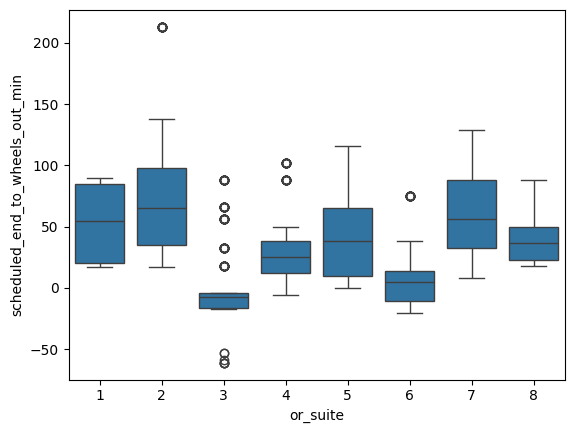

In [92]:
sns.boxplot(x='or_suite', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

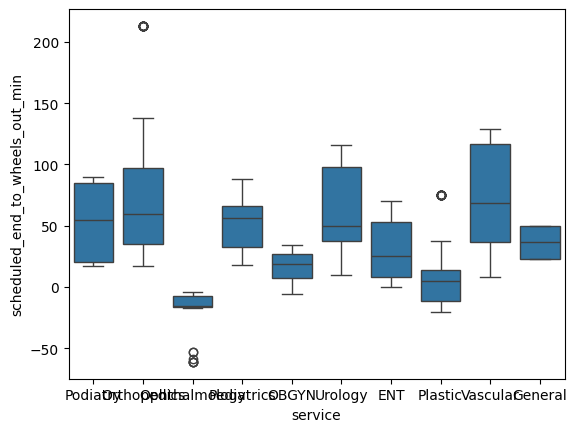

In [93]:
sns.boxplot(x='service', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

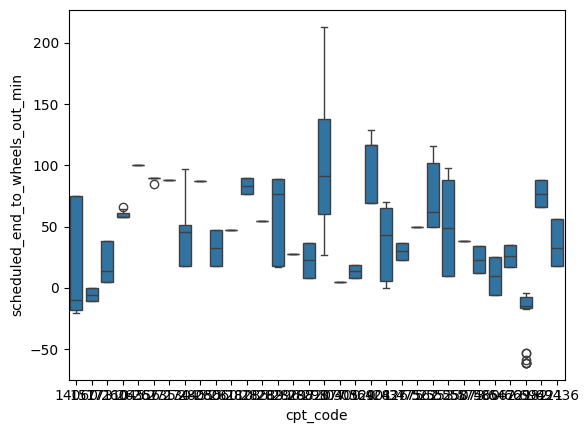

In [94]:
sns.boxplot(x='cpt_code', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

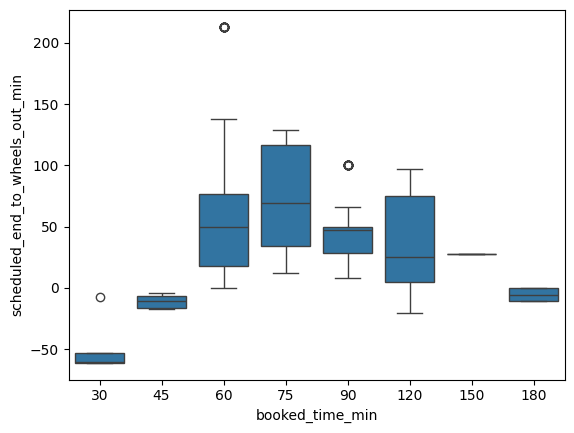

In [95]:
sns.boxplot(x='booked_time_min', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

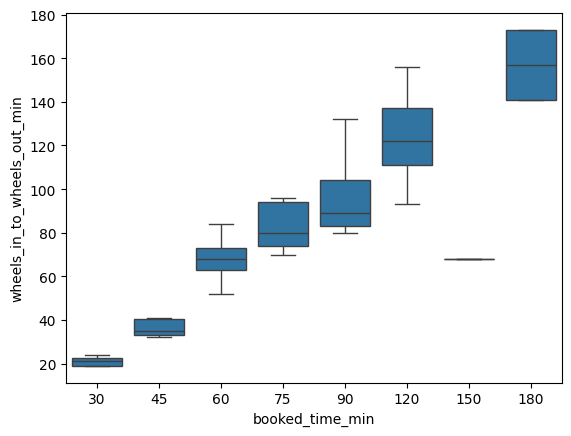

In [148]:
sns.boxplot(x='booked_time_min', y='wheels_in_to_wheels_out_min', data=or_intervals)
plt.show()

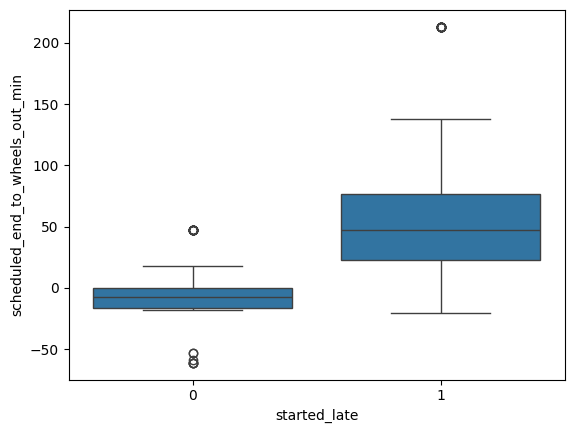

In [96]:
sns.boxplot(x='started_late', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

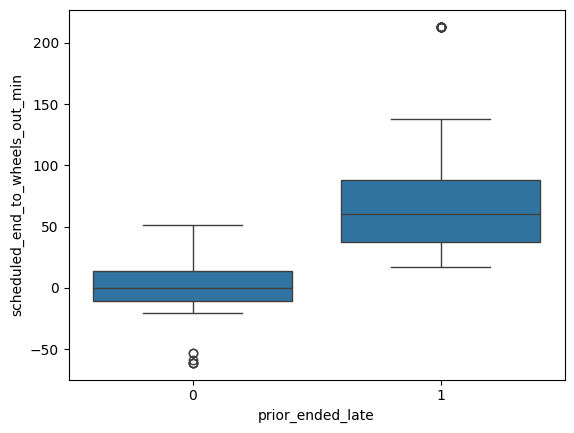

In [97]:
sns.boxplot(x='prior_ended_late', y='scheduled_end_to_wheels_out_min', data=or_intervals)
plt.show()

In [163]:
# What time do surgeries end compared to scheduled end of day?

print(sqldf("""
            with end_of_day as (
                        select 
                        encounter_date
                               , or_suite
                        , max(scheduled_end_time) as scheduled_end_of_day
                        , max(end_time) as actual_end_of_day
                                from or_intervals
                        group by 1, 2
            )
        select 
            --or_suite
             avg((strftime('%s', actual_end_of_day) - strftime('%s', scheduled_end_of_day))/60) as avg_end_of_day_diff
        from end_of_day
            --group by 1
            
            
            """))

   avg_end_of_day_diff
0            55.383065
